# iRacing session results analysis

In [11]:
import requests
import json
import urllib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 

 |->
 Input cell: enter subsession id and cookie to access session results:

In [12]:
subsessionId = '34798218'
custId = '182490'
cookie = ''

Retreive data from iRacing server:

In [13]:
cookies = {'irsso_membersv2': cookie}
payload = {'subsessionID': subsessionId, 'custid': custId }
responce = requests.post('https://members.iracing.com/membersite/member/GetSubsessionResults', data=payload, cookies=cookies)

resultJson = json.loads(responce.text)

Retrieve a list of classes and checks if this is a team race for convenience:

In [14]:
rows = resultJson['rows']
classes = []

isTeamRace = (resultJson['max_team_drivers'] > 1)

for row in rows:
    if row['simsestypename'] != 'Race' or (isTeamRace and row['custid'] >= 0):
        continue
    currentClassName = row['ccName'].replace('+', ' ')
    if not currentClassName in classes:
        classes.append(currentClassName)
if isTeamRace:
    print('This event is a team race')
else:
    print('This event is a single driver race')
print('Available classes:')
print(classes)

This event is a single driver race
Available classes:
['LMP1 Class', 'Dallara P217', 'GTE Class 3']


|->
Input cell: set class filter if needed (or `None` if no class filtering required):

In [15]:
className = 'LMP1 Class'

Retrieve lap time data for each car in a session and pack it to a pandas dataframe 

In [16]:
df = pd.DataFrame(columns = ['Team name', 'Driver name', 'Class name', 'Finish position', 'Class finish position',  'Lap num', 'Lap time', 'Flags'])

maximumLapNumber = 0

driverIds = {}
for row in rows:
    if row['simsestypename'] != 'Race' or (isTeamRace and row['custid'] >= 0):
        continue
    currentClassName = row['ccName'].replace('+', ' ')
    if not className is None and currentClassName != className:
        continue

    if isTeamRace:
        teamName = urllib.parse.unquote(row['displayname'].replace('+', ' '))
    else:
       teamName = '-'

    lapsResponse = requests.post('https://members.iracing.com/membersite/member/GetLaps?&subsessionid=' + subsessionId + '&groupid=' + str(row['custid']) + "&simsesnum=0", cookies=cookies)
    lapsJson = json.loads(lapsResponse.text)

    drivers = lapsJson['drivers']
    for driver in drivers:
        driverIds[driver['custid']] = urllib.parse.unquote(driver['displayname'].replace('+', ' '))
    prevLapSessTime = 0
    laps = lapsJson['lapData']
    for lap in laps:
        data = {}
        lapTime = (lap['ses_time'] - prevLapSessTime) / 10000.0
        prevLapSessTime = lap['ses_time']
        
        data['Team name'] = teamName
        data['Driver name'] = driverIds[lap['custid']]
        data['Class name'] = currentClassName
        data['Finish position'] = row['finishpos'] + 1
        data['Class finish position'] = row['finishposinclass'] + 1
        data['Lap num'] = lap['lap_num']
        data['Lap time'] = lapTime
        data['Flags'] = lap['flags']

        df = df.append(data, ignore_index=True)

df


,Team name,Driver name,Class name,Finish position,Class finish position,Lap num,Lap time,Flags
0,-,Lennart Rahrt,LMP1 Class,1,1,0,337.0177,0
1,-,Lennart Rahrt,LMP1 Class,1,1,1,102.8726,8192
2,-,Lennart Rahrt,LMP1 Class,1,1,2,98.0764,0
3,-,Lennart Rahrt,LMP1 Class,1,1,3,97.9140,0
4,-,Lennart Rahrt,LMP1 Class,1,1,4,98.1403,0
...,...,...,...,...,...,...,...,...
284,-,Javier Tuero,LMP1 Class,8,8,30,102.7576,0
285,-,Javier Tuero,LMP1 Class,8,8,31,101.7540,0
286,-,Javier Tuero,LMP1 Class,8,8,32,102.7145,4
287,-,Javier Tuero,LMP1 Class,8,8,33,105.6616,4


Compute lap time delta from a leader car for each lap:

In [17]:
lapIdxs = list(df['Lap num'].unique())
grouped = df.groupby('Lap num')

deltas = pd.DataFrame(columns = ['Team name', 'Lap time', 'Delta'])

for lapIdx in lapIdxs:
    lapResults = grouped.get_group(lapIdx)
    lapResults = lapResults.filter(['Lap time'])
    firstRow = True
    for index, row in lapResults.iterrows():
        if firstRow:
            currentLeaderTime = row['Lap time']
            firstRow = False
        delta = row['Lap time'] - currentLeaderTime
        lapResults.at[index, 'Delta'] = delta
    deltas = deltas.append(lapResults)
deltas = deltas.filter(['Delta'])
df = df.merge(deltas, how='left', left_index=True, right_index=True)
df

,Team name,Driver name,Class name,Finish position,Class finish position,Lap num,Lap time,Flags,Delta
0,-,Lennart Rahrt,LMP1 Class,1,1,0,337.0177,0,0.0000
1,-,Lennart Rahrt,LMP1 Class,1,1,1,102.8726,8192,0.0000
2,-,Lennart Rahrt,LMP1 Class,1,1,2,98.0764,0,0.0000
3,-,Lennart Rahrt,LMP1 Class,1,1,3,97.9140,0,0.0000
4,-,Lennart Rahrt,LMP1 Class,1,1,4,98.1403,0,0.0000
...,...,...,...,...,...,...,...,...,...
284,-,Javier Tuero,LMP1 Class,8,8,30,102.7576,0,2.9009
285,-,Javier Tuero,LMP1 Class,8,8,31,101.7540,0,1.4876
286,-,Javier Tuero,LMP1 Class,8,8,32,102.7145,4,3.0134
287,-,Javier Tuero,LMP1 Class,8,8,33,105.6616,4,6.0093


Compute accumulated gap from a leader car for each car:

In [18]:
if isTeamRace:
    carIdColumn = 'Team name'
else:
    carIdColumn = 'Driver name'
carIds = list(df[carIdColumn].unique())

gaps = pd.DataFrame(columns = ['Delta', 'Gap'])

grouped = df.groupby(carIdColumn)
for carId in carIds:
    carResults = grouped.get_group(carId)
    carResults = carResults.filter(['Delta'])
    gap = 0
    for index, row in carResults.iterrows():
        gap += row['Delta']
        carResults.at[index, 'Gap'] = gap
    gaps = gaps.append(carResults)
gaps = gaps.filter(['Gap'])
df = df.merge(gaps, how='left', left_index=True, right_index=True)
df

,Team name,Driver name,Class name,Finish position,Class finish position,Lap num,Lap time,Flags,Delta,Gap
0,-,Lennart Rahrt,LMP1 Class,1,1,0,337.0177,0,0.0000,0.0000
1,-,Lennart Rahrt,LMP1 Class,1,1,1,102.8726,8192,0.0000,0.0000
2,-,Lennart Rahrt,LMP1 Class,1,1,2,98.0764,0,0.0000,0.0000
3,-,Lennart Rahrt,LMP1 Class,1,1,3,97.9140,0,0.0000,0.0000
4,-,Lennart Rahrt,LMP1 Class,1,1,4,98.1403,0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...
284,-,Javier Tuero,LMP1 Class,8,8,30,102.7576,0,2.9009,260.5084
285,-,Javier Tuero,LMP1 Class,8,8,31,101.7540,0,1.4876,261.9960
286,-,Javier Tuero,LMP1 Class,8,8,32,102.7145,4,3.0134,265.0094
287,-,Javier Tuero,LMP1 Class,8,8,33,105.6616,4,6.0093,271.0187


Basic data is ready, now we can build some nice graphs:

In [19]:
data = []
labels = []

grouped = df.groupby(carIdColumn)
for carId in carIds:
    labels.append(carId)
    carResults = grouped.get_group(carId)
    data.append(carResults['Gap'].values)


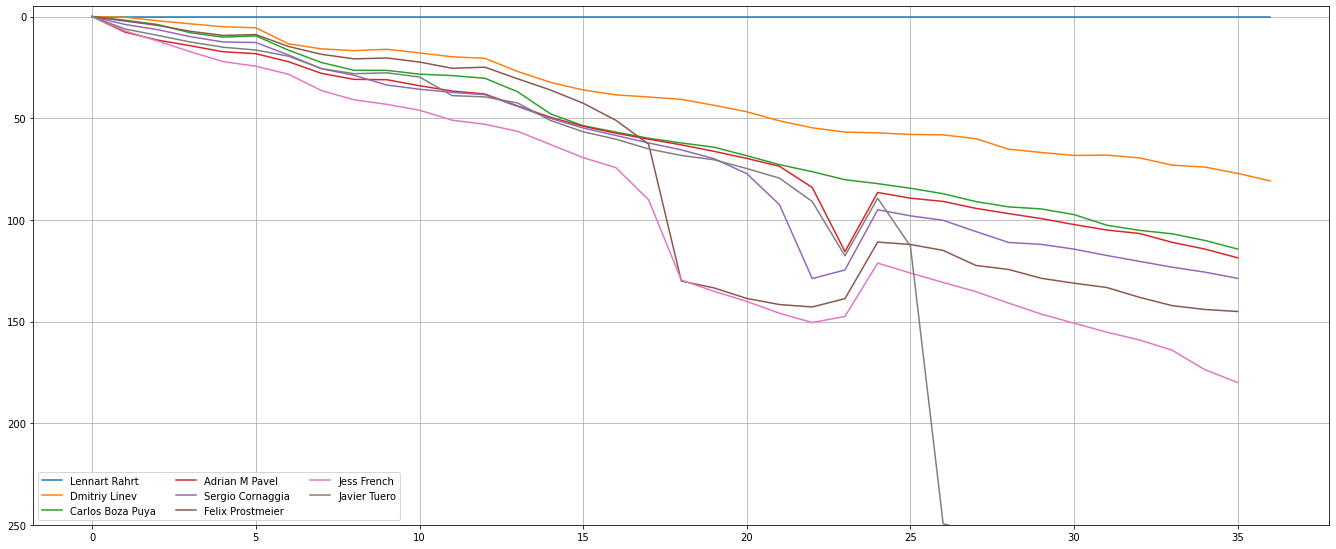

In [23]:
plt.rcParams['figure.figsize'] = [20, 8]

for i, gap in enumerate(data):
    plt.plot(gap, label=labels[i])
plt.legend(ncol=3)
# plt.xticks(np.arange(0, 24, 1.0))
plt.grid(True)
plt.gca().set_ylim([250 ,-5])
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()